# Solving Bin Packing Problem with Amazon SageMaker RL

This notebook shows an example of how to use reinforcement learning to solve the online stochastic bin packing problem. In the classic version of bin packing, we are given items of different sizes and need to pack them into as few bins as possible. In the online stochastic version, items arrive one at a time and item sizes are drawn from an unknown distribution. The task is to find a feasible packing that minimizes the number of bins used to pack all of the items that arrive within the time horizon.

## Problem Statement

In the stochastic bin packing problem, items arrive online, one in each time period $t$, with $t\in \{1,\dots,T\}$. Items can be of different sizes. Upon arrival, the item needs to be packed into one of the bins, each with size $B$. We assume the number of bins one can open is unlimited and denote the sum of item sizes in a bin $k$ as level $h_k$. After $t$ items have been packed, we denote the number of bins at some level $h$ as $N_h(t)$, where $h\in\{1,\dots,B\}$.

Assume bin size $B = 10$ and the usage at time $t$ is illustrated as below. Then $N_9(t) = 4$, $N_6(t) = 2$, and $N_2(t) = 3$.

<img src="images/rl_bin_packing.png" width="300" align="center"/>

This problem can be formulated as an Markov Decision Process (MDP), where the state $S_t$ is current item size and the number of bins at each level: $N_h(t)$. The action $A$ is to pick a bin level which can fit the item. Thus, the number of actions possible is $B$ with one action for each level and action $0$ corresponds to opening a new bin. Initially, all the bins are empty. The reward $R_t$ is the negative of incremental waste as each item is put into a bin. If the item is put into an existing bin, the incremental waste will reduce by item size. If the item is put into a new bin, the waste increases by the empty space left in the new bin. Invalid actions such as picking a level for which bins do not exist yet are masked.

## Using Amazon SageMaker RL

Amazon SageMaker RL allows you to train your RL agents in cloud machines using docker containers. You do not have to worry about setting up your machines with the RL toolkits and deep learning frameworks. You can easily switch between many different machines setup for you, including powerful GPU machines that give a big speedup. You can also choose to use multiple machines in a cluster to further speedup training, often necessary for production level loads.

## Pre-requsites
### Roles and permissions

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [1]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata. 

In [2]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-west-2-775004277940/


### Define Variables 

We define variables such as the job prefix for the training jobs *and the image path for the container (only when this is BYOC).*

In [23]:
# create a descriptive job name 
job_name_prefix = 'rl-binpacking'

### Configure where training happens

You can train your RL training jobs using the SageMaker notebook instance or local notebook instance. In both of these scenarios, you can run the following in either local or SageMaker modes. The local mode uses the SageMaker Python SDK to run your code in a local container before deploying to SageMaker. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set `local_mode = True`.

In [4]:
# run in local_mode on this machine, or as a SageMaker TrainingJob?
local_mode = False

if local_mode:
    instance_type = 'local'
else:
    # If on SageMaker, pick the instance type
    instance_type = "ml.c5.2xlarge"

### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running locally, set it to an IAM role with `AmazonSageMakerFullAccess` and `CloudWatchFullAccess permissions`.

In [5]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Couldn't call 'get_role' to get Role ARN from role name annaluo to get Role path.


Using IAM role arn: arn:aws:iam::775004277940:role/sagemaker


### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from you local instance, please make sure that you have docker or docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script 

Note, you can only run a single local notebook at one time.

In [6]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

## Setup the environment

The environment is defined in a Python file called `bin_packing_env.py` in the `./src` directory. It implements the `init()`, `step()` and `reset()` functions that describe how the environment behaves. This is consistent with Open AI Gym interfaces for defining an environment.

- Init() - initialize the environment in a pre-defined state
- Step() - take an action on the environment
- reset()- restart the environment on a new episode
- [if applicable] render() - get a rendered image of the environment in its current state

In [7]:
# uncomment the following line to see the environment
# !pygmentize src/bin_packing_env.py

## Write the training code

The training code is written in the file `train_bin_packing.py` which is also uploaded in the `/src` directory. 
First import the environment files and the preset files, and then define the main() function. 

In [8]:
!pygmentize src/train_bin_packing.py

from ray.tune.registry import register_env

from model import register_actor_mask_model
from sagemaker_rl.ray_launcher import SageMakerRayLauncher

register_actor_mask_model()


class MyLauncher(SageMakerRayLauncher):

    def register_env_creator(self):
        from bin_packing_env import BinPackingActionMaskGymEnvironment
        register_env("BinPackingActionMaskGymEnvironment-v1",
                     lambda env_config: BinPackingActionMaskGymEnvironment(env_config))

    def get_experiment_config(self):
        multi = 1
        return {
            "training": {
                "env": "BinPackingActionMaskGymEnvironment-v1",
                "run": "PPO",
                "config": {
                    "gamma": 0.995,
                    "kl_coeff": 1.0,
                    "num_sgd_iter": 10,
                    "lr": 0.0001,
                    "sgd_minibatch_size": 32768,
                    "train_batch_size": 320000,
                    "use_gae": False,
                    "

## Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The [RLEstimator](https://sagemaker.readthedocs.io/en/stable/sagemaker.rl.html) is used for training RL jobs. 

1. Specify the source directory where the gym environment and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. The RLCOACH_PRESET or the RLRAY_PRESET can be used to specify the RL agent algorithm you want to use. 
6. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks.

### Define Metric
A list of dictionaries that defines the metric(s) used to evaluate the training jobs. Each dictionary contains two keys: ‘Name’ for the name of the metric, and ‘Regex’ for the regular expression used to extract the metric from the logs.

In [9]:
metric_definitions = [{'Name': 'episode_reward_mean',
  'Regex': 'episode_reward_mean: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_reward_max',
  'Regex': 'episode_reward_max: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_len_mean',
  'Regex': 'episode_len_mean: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'entropy',
  'Regex': 'entropy: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_reward_min',
  'Regex': 'episode_reward_min: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'vf_loss',
  'Regex': 'vf_loss: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'policy_loss',
  'Regex': 'policy_loss: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},                                            
]

### Define Estimator
This Estimator executes an RLEstimator script in a managed Reinforcement Learning (RL) execution environment within a SageMaker Training Job. The managed RL environment is an Amazon-built Docker container that executes functions defined in the supplied entry_point Python script.

In [36]:
train_entry_point = "train_bin_packing.py"
train_job_max_duration_in_seconds = 60 * 10

estimator = RLEstimator(entry_point=train_entry_point,
                        source_dir="src",
                        dependencies=["common/sagemaker_rl"],
                        toolkit=RLToolkit.RAY,
                        toolkit_version='0.6.5',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        train_max_run=train_job_max_duration_in_seconds,
                        hyperparameters={}
                       )

In [37]:
estimator.fit(wait=local_mode)

job_name=estimator._current_job_name
print("Job name: {}".format(job_name))

## Visualization

RL training can take a long time.  So while it's running there are a variety of ways we can track progress of the running training job.  Some intermediate output gets saved to S3 during training, so we'll set up to capture that.

In [39]:
s3_url = "s3://{}/{}".format(s3_bucket,job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
intermediate_url = "s3://{}/{}training/".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Intermediate folder path: {}".format(intermediate_url))

Job name: rl-binpacking-2019-11-25-18-20-31-915
S3 job path: s3://sagemaker-us-west-2-775004277940/rl-binpacking-2019-11-25-18-20-31-915
Intermediate folder path: s3://sagemaker-us-west-2-775004277940/rl-binpacking-2019-11-25-18-20-31-915/output/intermediate/training/
Create local folder /tmp/rl-binpacking-2019-11-25-18-20-31-915


### Plot metrics for training job
We can see the reward metric of the training as it's running, using algorithm metrics that are recorded in CloudWatch metrics.  We can plot this to see the performance of the model over time.

In [40]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

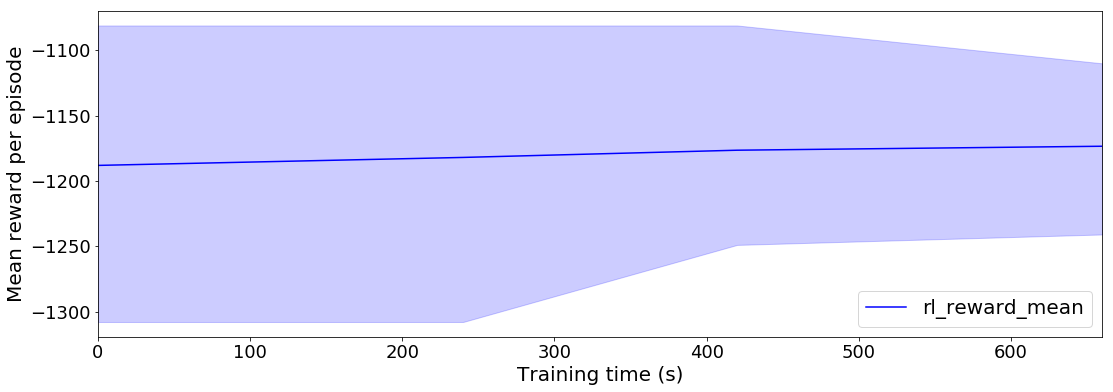

In [41]:
if not local_mode:
    df = TrainingJobAnalytics(job_name, ['episode_reward_mean']).dataframe()
    df_min = TrainingJobAnalytics(job_name, ['episode_reward_min']).dataframe()
    df_max = TrainingJobAnalytics(job_name, ['episode_reward_max']).dataframe()
    df['rl_reward_mean'] = df['value']
    df['rl_reward_min'] = df_min['value']
    df['rl_reward_max'] = df_max['value']
    num_metrics = len(df)
    
    if num_metrics == 0:
        print("No algorithm metrics found in CloudWatch")
    else:
        plt = df.plot(x='timestamp', y=['rl_reward_mean'], figsize=(18,6), fontsize=18, legend=True, style='-', color=['b','r','g'])
        plt.fill_between(df.timestamp, df.rl_reward_min, df.rl_reward_max, color='b', alpha=0.2)
        plt.set_ylabel('Mean reward per episode', fontsize=20)
        plt.set_xlabel('Training time (s)', fontsize=20)
        plt.legend(loc=4, prop={'size': 20})
else:
    print("Can't plot metrics in local mode.")

#### Monitor training progress
You can repeatedly run the visualization cells to get the latest metrics as the training job proceeds.

## Training Results

You can let the training job run longer by specifying `train_max_run` in `RLEstimator`. The figure below illustrates the reward function of the RL policy vs. that of Best Fit, a classic heuristic. The sub-figures correspond to three categories of the item distribution, Perfectly Packable with Bounded Waste (BW), Perfectly Packable (PP) and Linear Waste (LW) respectively. The experiments are conducted on a p3.8x instance. For more details on the environment setup and how different parameters are set, please refer to [ORL: Reinforcement Learning Benchmarks for Online Stochastic Optimization
Problems](https://arxiv.org/pdf/1911.10641.pdf).

![rl_bin_packing_result](images/rl_bin_packing_result.png)